# Importing the Datasets

In [86]:
import requests

# URL of the JSON file
url = "https://raw.githubusercontent.com/tejaswitripathi/parkscores-with-population/refs/heads/main/top100.json"

# Fetch and load the JSON file into a dictionary
response = requests.get(url)
response.raise_for_status()  # Ensure the request was successful
parkscores = response.json()

# Get the main keys in the dictionary
main_keys = list(parkscores.keys())
print(main_keys)


['Albuquerque, NM', 'Anaheim, CA', 'Anchorage, AK', 'Arlington, TX', 'Arlington, VA', 'Atlanta, GA', 'Aurora, CO', 'Austin, TX', 'Bakersfield, CA', 'Baltimore, MD', 'Baton Rouge, LA', 'Boise, ID', 'Boston, MA', 'Buffalo, NY', 'Chandler, AZ', 'Charlotte/Mecklenburg, NC', 'Chesapeake, VA', 'Chicago, IL', 'Chula Vista, CA', 'Cincinnati, OH', 'Cleveland, OH', 'Colorado Springs, CO', 'Columbus, OH', 'Corpus Christi, TX', 'Dallas, TX', 'Denver, CO', 'Detroit, MI', 'Durham, NC', 'El Paso, TX', 'Fort Worth, TX', 'Fremont, CA', 'Fresno, CA', 'Garland, TX', 'Gilbert, AZ', 'Glendale, AZ', 'Greensboro, NC', 'Henderson, NV', 'Honolulu, HI', 'Houston, TX', 'Irvine, CA', 'Irving, TX', 'Jacksonville, FL', 'Jersey City, NJ', 'Kansas City, MO', 'Laredo, TX', 'Las Vegas, NV', 'Lexington/Fayette, KY', 'Lincoln, NE', 'Long Beach, CA', 'Los Angeles, CA', 'Louisville, KY', 'Lubbock, TX', 'Madison, WI', 'Memphis, TN', 'Mesa, AZ', 'Miami, FL', 'Milwaukee, WI', 'Minneapolis, MN', 'Nashville/Davidson, TN', 'New 

In [87]:
# Loop through each city in the main dictionary
for city_name, categories in parkscores.items():
    print(f"City: {city_name}")

    # Check if the value is a list and contains dictionaries
    if isinstance(categories, list) and all(isinstance(item, dict) for item in categories):
        # Get the keys from the dictionaries in the list
        category_keys = {key for entry in categories for key in entry.keys()}
        print(f"Keys in categories for {city_name}: {category_keys}")
        avg_pts = [entry.get('Avg. Points') for entry in categories]
        print(f"'Avg. Points' value for {city_name}: {avg_pts[-1]}")
    else:
        print(f"No valid categories found for {city_name}")
    print("-" * 40)


City: Albuquerque, NM
Keys in categories for Albuquerque, NM: {'Text', 'Per Cap Data', 'Category', 'Total Data', 'Avg. Points'}
'Avg. Points' value for Albuquerque, NM: 65.8
----------------------------------------
City: Anaheim, CA
Keys in categories for Anaheim, CA: {'Text', 'Per Cap Data', 'Category', 'Total Data', 'Avg. Points'}
'Avg. Points' value for Anaheim, CA: 42.4
----------------------------------------
City: Anchorage, AK
Keys in categories for Anchorage, AK: {'Text', 'Per Cap Data', 'Category', 'Total Data', 'Avg. Points'}
'Avg. Points' value for Anchorage, AK: 49.2
----------------------------------------
City: Arlington, TX
Keys in categories for Arlington, TX: {'Text', 'Per Cap Data', 'Category', 'Total Data', 'Avg. Points'}
'Avg. Points' value for Arlington, TX: 53.2
----------------------------------------
City: Arlington, VA
Keys in categories for Arlington, VA: {'Text', 'Per Cap Data', 'Category', 'Total Data', 'Avg. Points'}
'Avg. Points' value for Arlington, VA: 7

In [88]:
import sqlite3
# Drop the existing table


# # Recreate the table
# cursor.execute("""
# CREATE TABLE ParkScores (
#     city_name TEXT,
#     category TEXT,
#     per_cap_data REAL,
#     text TEXT,
#     total_data REAL,
#     avg_points REAL
# )
# """)

# Now proceed with inserting the data



# Connect to SQLite database (it will be created if it doesn't exist)
db_name = "parkscores.db"
conn = sqlite3.connect(db_name)
cursor = conn.cursor()
cursor.execute("DROP TABLE IF EXISTS ParkScores")

# Create a table to store park score data
cursor.execute("""
CREATE TABLE IF NOT EXISTS ParkScores (
    city_name TEXT,
    category TEXT,
    per_cap_data REAL,
    text TEXT,
    total_data REAL,
    avg_points REAL
)
""")

# Insert data into the database
for city_name, categories in parkscores.items():
    if isinstance(categories, list):  # Ensure it's a list of dictionaries
        for entry in categories:
            cursor.execute("""
            INSERT INTO ParkScores (city_name, category, per_cap_data, text, total_data, avg_points)
            VALUES (?, ?, ?, ?, ?, ?)
            """, (
                city_name,                           # The city name from the main key
                entry.get("Category"),               # The category name
                entry.get("Per Cap Data"),           # Per Capita Data
                entry.get("Text"),                   # Description text
                entry.get("Total Data"),             # Total Data
                entry.get("Avg. Points")             # Average Points
            ))

# Commit changes and close the connection
conn.commit()
conn.close()

print(f"Data successfully stored in {db_name}")


Data successfully stored in parkscores.db


In [89]:
# Connect to SQLite database
db_name = "parkscores.db"
conn = sqlite3.connect(db_name)
cursor = conn.cursor()

# Step 1: Remove "Total Data" column from ParkScores table
# Create a temporary table without the "Total Data" column
cursor.execute("""
CREATE TABLE IF NOT EXISTS TempParkScores (
    city_name TEXT,
    category TEXT,
    per_cap_data REAL,
    text TEXT,
    avg_points REAL
)
""")

# Copy data to TempParkScores excluding "Total Data"
cursor.execute("""
INSERT INTO TempParkScores (city_name, category, per_cap_data, text, avg_points)
SELECT city_name, category, per_cap_data, text, avg_points
FROM ParkScores
""")

# Drop the original ParkScores table
cursor.execute("DROP TABLE ParkScores")

# Rename TempParkScores to ParkScores
cursor.execute("ALTER TABLE TempParkScores RENAME TO ParkScores")

# Step 2: Create separate tables for each category
# Get the distinct categories
cursor.execute("SELECT DISTINCT category FROM ParkScores")
categories = [row[0] for row in cursor.fetchall()]

# Create a table for each category
for category in categories:
    # Create a new table
    table_name = category.replace(" ", "_")  # Replace spaces with underscores for table names
    cursor.execute(f"""
    CREATE TABLE IF NOT EXISTS {table_name} (
        city_name TEXT,
        per_cap_data REAL,
        text TEXT,
        avg_points REAL
    )
    """)

    # Insert data into the new table for this category
    cursor.execute(f"""
    INSERT INTO {table_name} (city_name, per_cap_data, text, avg_points)
    SELECT city_name, per_cap_data, text, avg_points
    FROM ParkScores
    WHERE category = ?
    """, (category,))

# Commit changes and close connection
conn.commit()
conn.close()

print("Database updated: 'Total Data' column removed, and separate tables created for each category.")


Database updated: 'Total Data' column removed, and separate tables created for each category.


In [90]:
import pandas as pd

# Connect to the SQLite database
db_name = "parkscores.db"
conn = sqlite3.connect(db_name)

# Step 1: Retrieve all category table names
cursor = conn.cursor()
cursor.execute("SELECT DISTINCT category FROM ParkScores")
categories = [row[0] for row in cursor.fetchall()]

# Step 2: Create a combined DataFrame
dfs = []  # List to hold individual DataFrames
for category in categories:
    # Replace spaces with underscores for table names
    table_name = category.replace(" ", "_")

    # Load data from each table
    df = pd.read_sql_query(f"SELECT city_name, avg_points FROM {table_name}", conn)
    df['category'] = category  # Add a category column
    dfs.append(df)

# Combine all category DataFrames
combined_df = pd.concat(dfs, ignore_index=True)

# Step 3: Aggregate duplicate entries by taking the mean of avg_points
combined_df = combined_df.groupby(['city_name', 'category'], as_index=False).agg({'avg_points': 'mean'})

# Step 4: Pivot the DataFrame to create separate columns for each category
df_parkscores = combined_df.pivot(index='city_name', columns='category', values='avg_points')

# Reset the index to make it easier to work with
df_parkscores.reset_index(inplace=True)

# Close the database connection
conn.close()

# Display the pivoted DataFrame
print(df_parkscores.head())


category        city_name  Access  Acreage  Amenities  Equity  Investment  \
0         Albuquerque, NM    87.0     61.5  57.500000   63.75        59.0   
1             Anaheim, CA    57.0     74.5  23.000000   28.25        29.0   
2           Anchorage, AK    68.0     70.0  35.166667   53.00        20.0   
3           Arlington, TX    60.0     64.0  57.833333   48.00        36.0   
4           Arlington, VA    99.0     36.0  89.666667   71.25       100.0   

category  Total  
0          65.8  
1          42.4  
2          49.2  
3          53.2  
4          79.2  


# Generating Data for Screen Time
Uncomment this code block if you are generating new synthetic data rather than using what we have already generated; otherwise, run as usual.

In [91]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# def generate_screentime_data(cities, num_records=200000):
#     # Define cities (locations)
#     # cities = city_names

#     # Define app categories
#     app_categories = [
#         "Social Media", "Entertainment", "Productivity", "Gaming", "Education",
#         "Health & Fitness", "Shopping", "Communication", "News", "Travel"
#     ]

#     # Generate random data
#     np.random.seed(42)  # for reproducibility


#     # Create the dataset
#     data = {
#         'user_id': np.random.randint(1, 10001, num_records),
#         'location': np.random.choice(cities, num_records),
#         'app_category': np.random.choice(app_categories, num_records),
#         'screentime_minutes': np.random.randint(1, 241, num_records),  # 1-240 minutes
#     }

#     # Create DataFrame
#     df = pd.DataFrame(data)


#     return df

# def analyze_dataset(df):
#     """Analyze the generated dataset and print basic statistics."""
#     print("\nDataset Analysis:")
#     print("-" * 50)
#     print(f"Total number of records: {len(df):,}")
#     print(f"Number of unique locations: {df['location'].nunique()}")
#     print(f"Number of unique users: {df['user_id'].nunique():,}")
#     # print(f"Date range: {df['date'].min()} to {df['date'].max()}")

#     print("\nAverage screentime by location (top 5):")
#     avg_screentime = df.groupby('location')['screentime_minutes'].mean().sort_values(ascending=False).head()
#     print(avg_screentime)

#     print("\nSample of first 5 records:")
#     print(df.head())

# # def save_dataset(df, filename='screentime.csv'):
# #     """Save the dataset to a CSV file."""
# #     df.to_csv(filename, index=False)
# #     print(f"\nDataset saved as '{filename}'")
# #     print(f"File size: {df.memory_usage(deep=True).sum() / (1024*1024):.2f} MB")



# # Generate the dataset
# df_screentime = generate_screentime_data(df_parkscores['city_name'], 200000)

# # Sort the DataFrame by the "Location" column in alphabetical order
# df_screentime = df_screentime.sort_values(by="location", ascending=True)

# # Reset the index to keep it clean
# df_screentime.reset_index(drop=True, inplace=True)

# # Display the sorted DataFrame
# print(df_screentime)

# # Analyze the dataset
# analyze_dataset(df_screentime)

In [92]:
# print(df_screentime.groupby("location")["screentime_minutes"].mean().reset_index())
# print(df_screentime.groupby("location")["screentime_minutes"].median().reset_index())

In [93]:
# import pandas as pd

# # Filter relevant app categories and create a pivot table
# filtered_categories = ["Social Media", "Health & Fitness"]
# df_filtered = df_screentime[df_screentime["app_category"].isin(filtered_categories)]

# # Pivot to get 'city_name' as rows and app categories as columns
# pivot_df = df_filtered.pivot_table(
#     index="location",
#     columns="app_category",
#     values="screentime_minutes",
#     aggfunc="median"
# ).reset_index()

# # Add a "Total" column for median screentime across all categories for each city
# total_screentime = df_screentime.groupby("location")["screentime_minutes"].median().reset_index()
# total_screentime.rename(columns={"screentime_minutes": "median_overall"}, inplace=True)

# # Merge the pivoted DataFrame with the total screentime
# df_screentime = pd.merge(pivot_df, total_screentime, on="location", how="left")

# # Rename columns for clarity
# df_screentime.rename(columns={"Social Media": "med_social_media", "Health & Fitness": "med_health_and_fitness", "location": "city_name"}, inplace=True)

# # Display the final DataFrame
# print(df_screentime)


Comment out the below code block if you are generating new synthetic data.

In [94]:
df_screentime = pd.read_csv("https://raw.githubusercontent.com/tejaswitripathi/parkscores-with-population/refs/heads/main/screentime.csv")

# Data Analyses

 Avg_Points

Avg_Points vs Median Overall Screentime
Correlation Coefficient: 0.11
Regression Slope: 0.02
Regression Intercept: 119.57



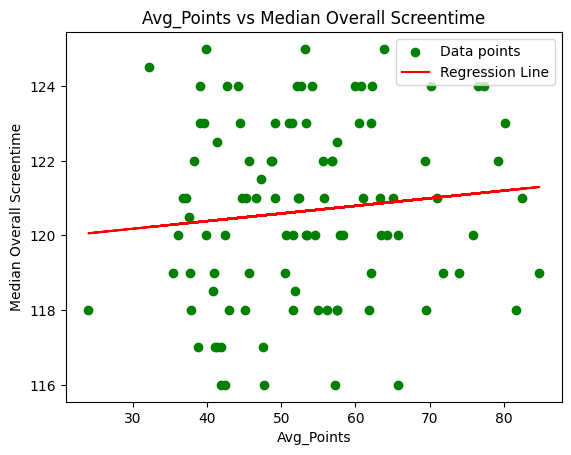

Avg_Points vs Social Media Screentime
Correlation Coefficient: 0.04
Regression Slope: 0.02
Regression Intercept: 118.93



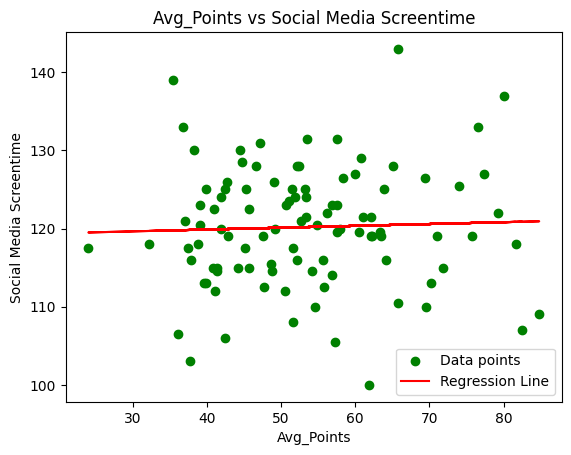

Avg_Points vs Health and Fitness Screentime
Correlation Coefficient: 0.13
Regression Slope: 0.07
Regression Intercept: 115.97



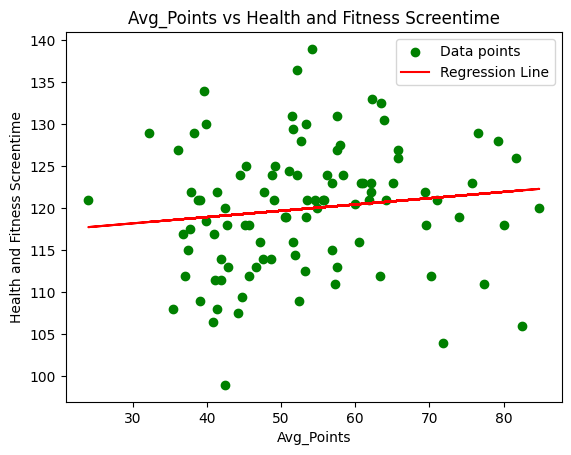

 Access

Access vs Median Overall Screentime
Correlation Coefficient: 0.04
Regression Slope: 0.00
Regression Intercept: 120.42



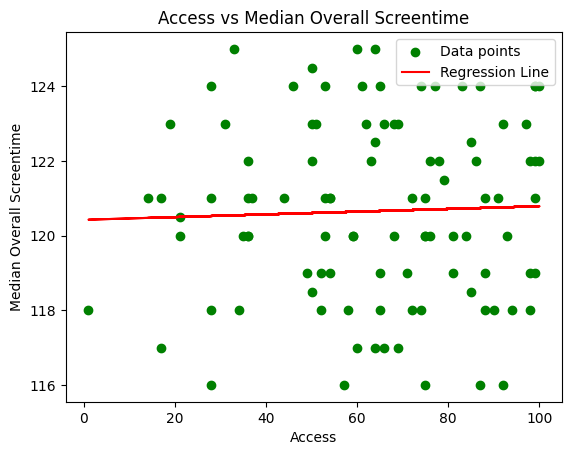

Access vs Social Media Screentime
Correlation Coefficient: -0.03
Regression Slope: -0.01
Regression Intercept: 120.83



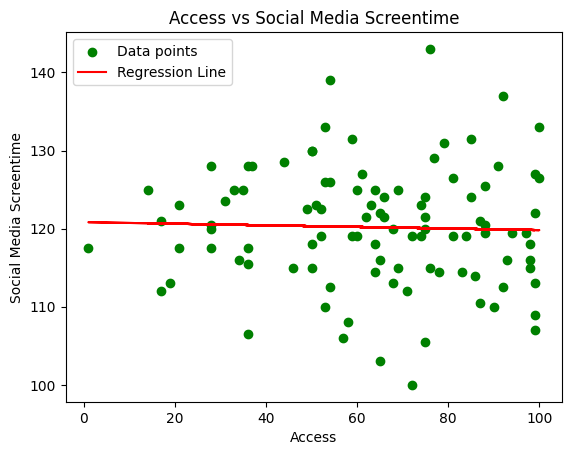

Access vs Health and Fitness Screentime
Correlation Coefficient: 0.10
Regression Slope: 0.03
Regression Intercept: 117.94



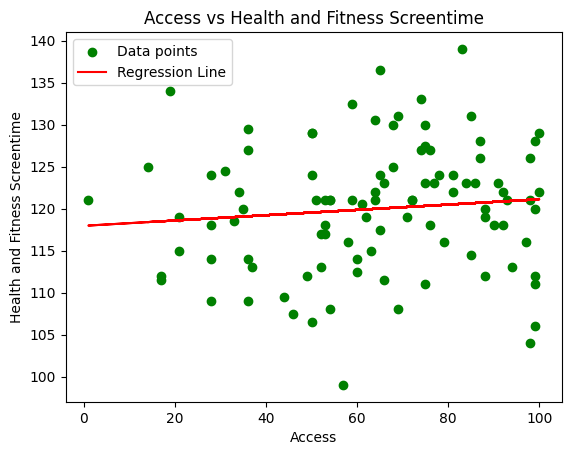

 Acreage

Acreage vs Median Overall Screentime
Correlation Coefficient: 0.08
Regression Slope: 0.01
Regression Intercept: 120.13



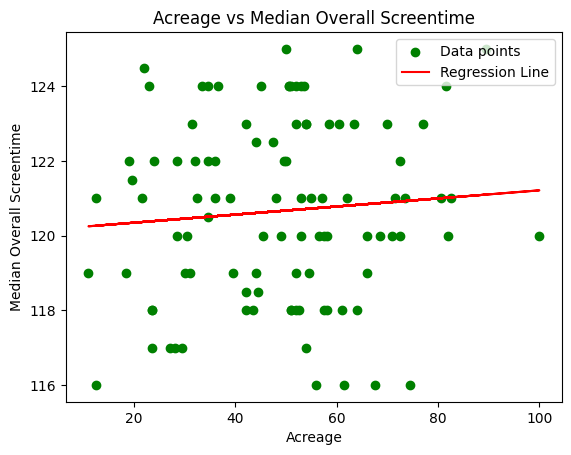

Acreage vs Social Media Screentime
Correlation Coefficient: 0.13
Regression Slope: 0.05
Regression Intercept: 117.63



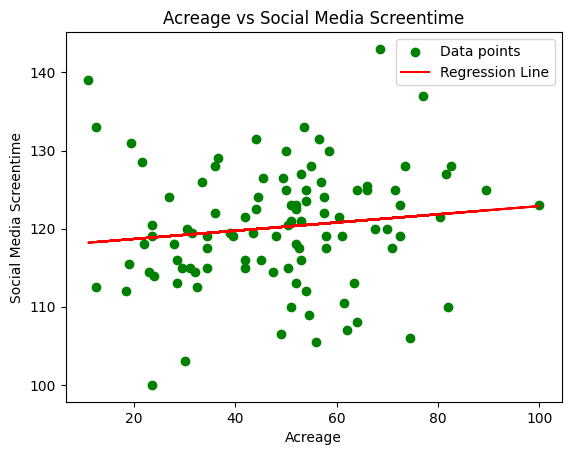

Acreage vs Health and Fitness Screentime
Correlation Coefficient: 0.03
Regression Slope: 0.01
Regression Intercept: 119.35



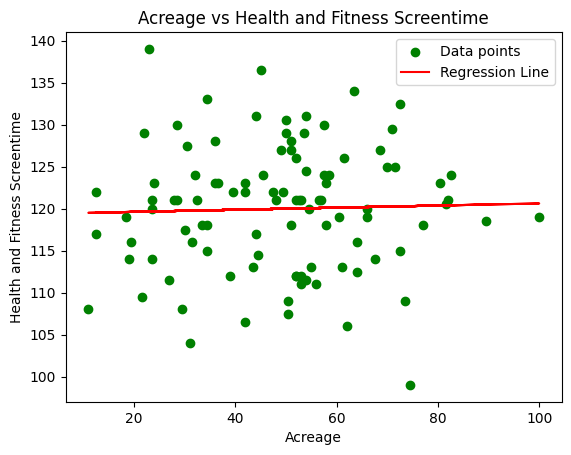

 Amenities

Amenities vs Median Overall Screentime
Correlation Coefficient: 0.08
Regression Slope: 0.01
Regression Intercept: 120.14



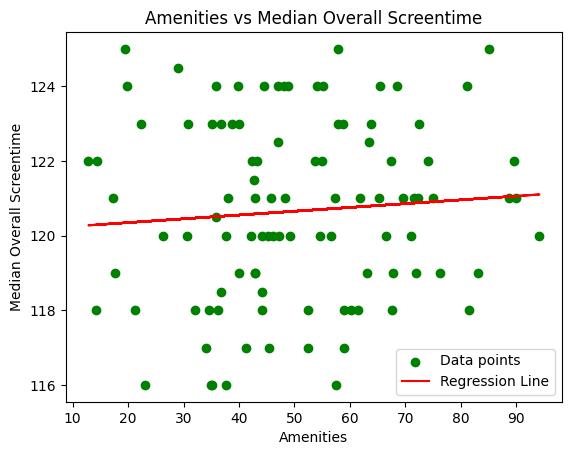

Amenities vs Social Media Screentime
Correlation Coefficient: -0.02
Regression Slope: -0.01
Regression Intercept: 120.53



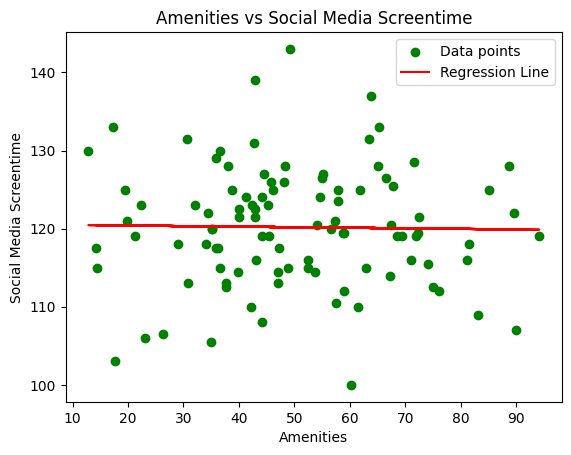

Amenities vs Health and Fitness Screentime
Correlation Coefficient: 0.06
Regression Slope: 0.02
Regression Intercept: 118.70



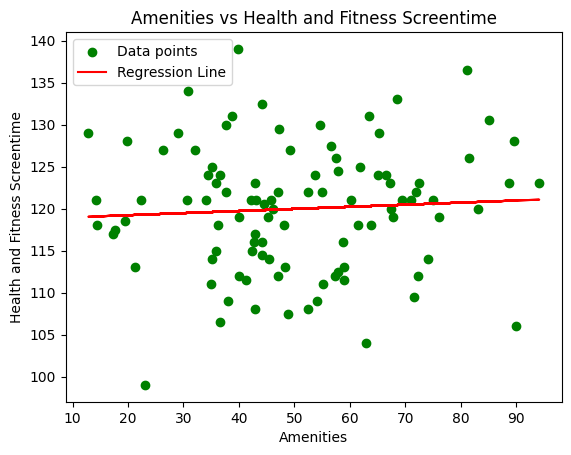

 Equity

Equity vs Median Overall Screentime
Correlation Coefficient: 0.04
Regression Slope: 0.01
Regression Intercept: 120.29



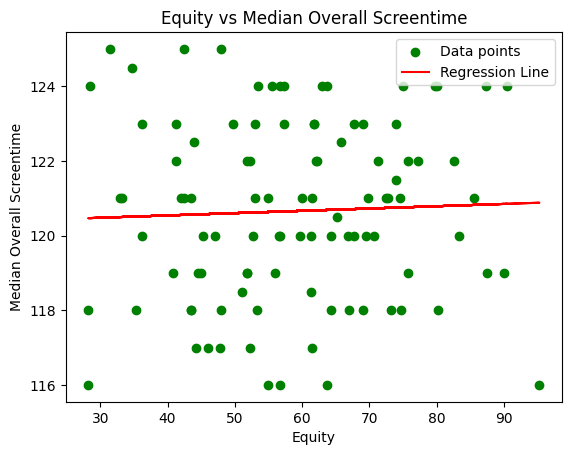

Equity vs Social Media Screentime
Correlation Coefficient: -0.01
Regression Slope: -0.00
Regression Intercept: 120.47



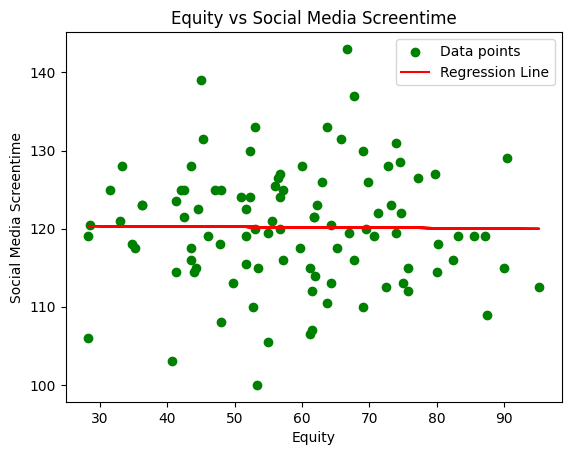

Equity vs Health and Fitness Screentime
Correlation Coefficient: 0.20
Regression Slope: 0.10
Regression Intercept: 114.37



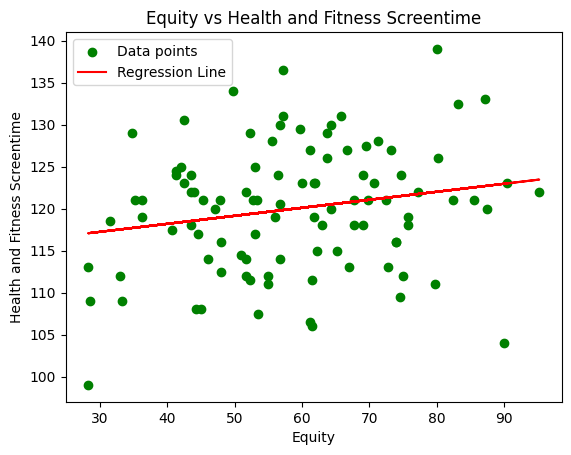

 Investment

Investment vs Median Overall Screentime
Correlation Coefficient: 0.09
Regression Slope: 0.01
Regression Intercept: 120.30



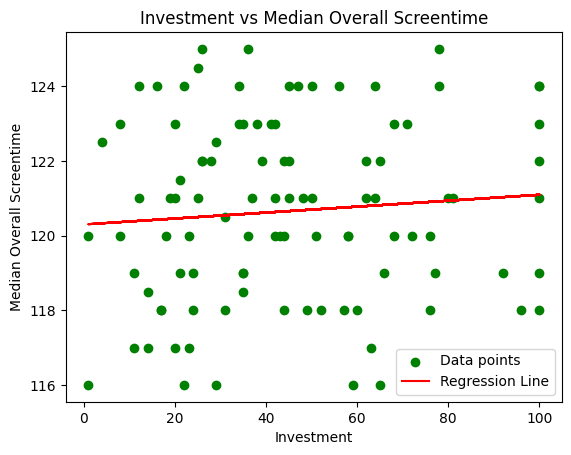

Investment vs Social Media Screentime
Correlation Coefficient: 0.05
Regression Slope: 0.02
Regression Intercept: 119.49



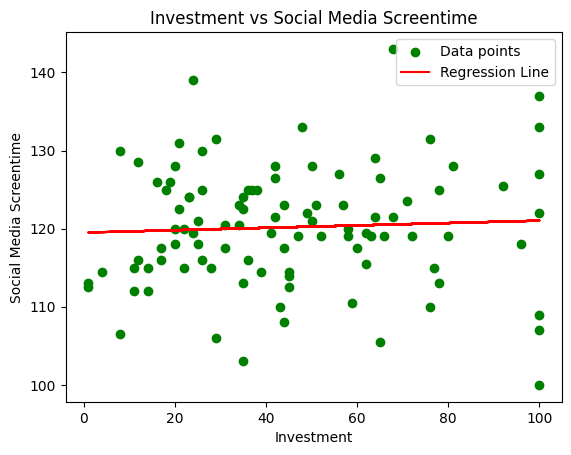

Investment vs Health and Fitness Screentime
Correlation Coefficient: 0.03
Regression Slope: 0.01
Regression Intercept: 119.60



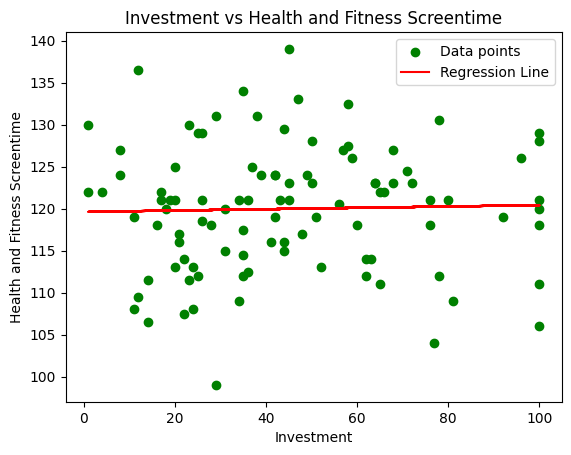

In [95]:

import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Function for regression analysis
def analyze_relationship(x_column, y_column, x_label, y_label, title):
    x = merged_df[x_column].values
    y = merged_df[y_column].values

    x_mean = np.mean(x)
    y_mean = np.mean(y)

    numerator = np.sum((x - x_mean) * (y - y_mean))
    denominator = np.sqrt(np.sum((x - x_mean) ** 2) * np.sum((y - y_mean) ** 2))
    correlation_coefficient = numerator / denominator

    print(f"{title}")
    print(f"Correlation Coefficient: {correlation_coefficient:.2f}")

    # Regression Analysis
    X = x.reshape(-1, 1)
    model = LinearRegression()
    model.fit(X, y)

    slope = model.coef_[0]
    intercept = model.intercept_
    print(f"Regression Slope: {slope:.2f}")
    print(f"Regression Intercept: {intercept:.2f}\n")

    # Visualization
    plt.scatter(x, y, color='green', label='Data points')
    plt.plot(x, model.predict(X), color='red', label='Regression Line')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()


merged_df = pd.merge(df_parkscores, df_screentime, on='city_name', how='inner')
merged_df.rename(columns={"Total": "Avg_Points"}, inplace=True)

# columns to analyze
columns = ["Avg_Points", "Access", "Acreage", "Amenities", "Equity", "Investment"]

# perform the analyses for each column
for col in columns:
    print(f" {col}\n")

    # Column vs total_screentime
    analyze_relationship(
        x_column=col,
        y_column='median_overall',
        x_label=col,
        y_label='Median Overall Screentime',
        title=f'{col} vs Median Overall Screentime'
    )

    # Column vs social_media
    analyze_relationship(
        x_column=col,
        y_column='med_social_media',
        x_label=col,
        y_label='Social Media Screentime',
        title=f'{col} vs Social Media Screentime'
    )

    # Column vs health_and_fitness
    analyze_relationship(
        x_column=col,
        y_column='med_health_and_fitness',
        x_label=col,
        y_label='Health and Fitness Screentime',
        title=f'{col} vs Health and Fitness Screentime'
    )



#  Train Test Split (Equity vs Health & Fitness Screentime)



Model Evaluation for Equity vs Health & Fitness Screentime:
Mean Squared Error: 41.19
R²: 0.05
Regression Slope: 0.09
Regression Intercept: 114.63


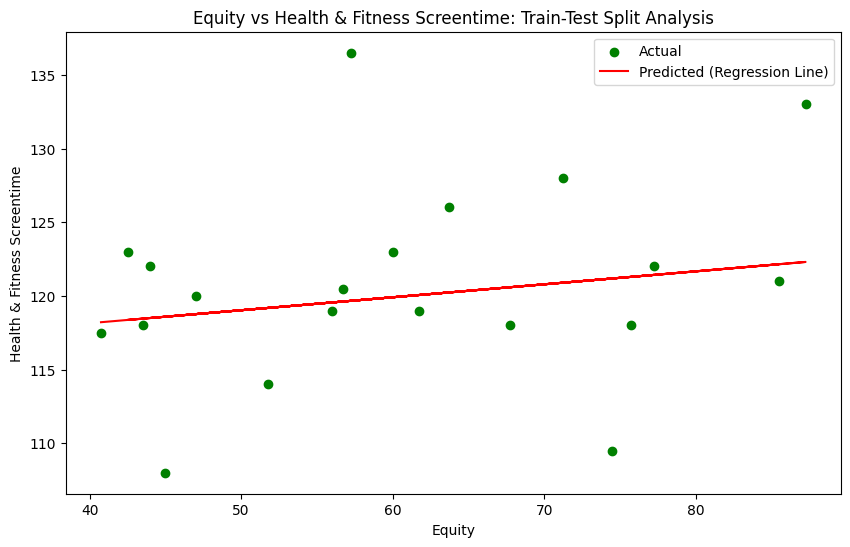

In [96]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

x = merged_df['Equity'].values.reshape(-1, 1)
y = merged_df['med_health_and_fitness'].values

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
slope = model.coef_[0]
intercept = model.intercept_

print(f"Model Evaluation for Equity vs Health & Fitness Screentime:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R²: {r2:.2f}")
print(f"Regression Slope: {slope:.2f}")
print(f"Regression Intercept: {intercept:.2f}")

plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='green', label='Actual')
plt.plot(X_test, y_pred, color='red', label='Predicted (Regression Line)')
plt.title("Equity vs Health & Fitness Screentime: Train-Test Split Analysis")
plt.xlabel("Equity")
plt.ylabel("Health & Fitness Screentime")
plt.legend()
plt.show()


## Train-Test Split (Avg_Points vs Health & Fitness)

Model Evaluation for Average Points vs Health & Fitness Screentime:
Mean Squared Error: 41.98
R²: 0.03
Regression Slope: 0.03
Regression Intercept: 118.09


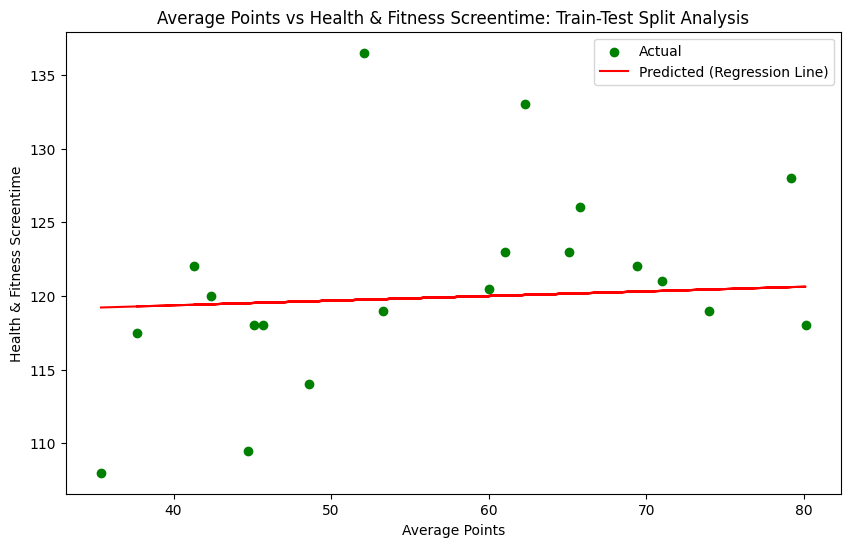

In [97]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

x = merged_df['Avg_Points'].values.reshape(-1, 1)
y = merged_df['med_health_and_fitness'].values

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
slope = model.coef_[0]
intercept = model.intercept_

print(f"Model Evaluation for Average Points vs Health & Fitness Screentime:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R²: {r2:.2f}")
print(f"Regression Slope: {slope:.2f}")
print(f"Regression Intercept: {intercept:.2f}")

plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='green', label='Actual')
plt.plot(X_test, y_pred, color='red', label='Predicted (Regression Line)')
plt.title("Average Points vs Health & Fitness Screentime: Train-Test Split Analysis")
plt.xlabel("Average Points")
plt.ylabel("Health & Fitness Screentime")
plt.legend()
plt.show()
